In [1]:
import sys
sys.path.append('../xrun')

In [2]:
import re

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from IPython.core.display import HTML
from sklearn.metrics import pairwise_distances

from xrun.data.run_info import RunInfo

In [3]:
def load_cost_from_file(file_path: Path):
    if file_path.exists():
            with open(file_path, "r") as f:
                return float(f.read())
    else:
        # print(f"Warning: {file_path} not found!")
        pass
    return None

def get_algorithm_name(run_info):
    if run_info.algorithm == "uniform-sampling":
        return "Uniform Sampling"
    elif run_info.algorithm == "sensitivity-sampling":
        return "Sensitivity Sampling"
    elif run_info.algorithm == "group-sampling":
        return "Group Sampling"
    return "Unknown"

def get_dataset_print_name(run_info):
    d = {
        "census": "Census",
        "covertype": "Covertype",
        "tower": "Tower",
    }
    if run_info.dataset in d:
        return d[run_info.dataset]
    return run_info.dataset
    
def get_costs(file_paths):
    costs = []
    for index, run_file_path in enumerate(file_paths):
        run_info = RunInfo.load_json(run_file_path)
        real_cost = load_cost_from_file(run_file_path.parent / "real_cost.txt")
        coreset_cost = load_cost_from_file(run_file_path.parent / "coreset_cost.txt")
        distortion = load_cost_from_file(run_file_path.parent / "distortion.txt")
        costs.append({
            "dataset": get_dataset_print_name(run_info),
            "algorithm": get_algorithm_name(run_info),
            "k": run_info.k,
            "coreset_size": run_info.m,
            "coreset_size_factor": run_info.m / run_info.k,
            "running_time": int(run_info.duration_secs),
            "real_cost": real_cost,
            "coreset_cost": coreset_cost,
            "distortion": distortion,
            "run_file_path": str(run_file_path),
        })
    df_data = pd.DataFrame(costs)
    return df_data

def aggregate_costs(df_costs: pd.DataFrame):
    group_columns = ["dataset", "algorithm", "k", "coreset_size_factor"]
    df_top_k = df_costs.groupby(group_columns, as_index=False).head(10)
    df_aggr_costs = df_top_k.groupby(group_columns, as_index=False).agg(
        experiment_count=("algorithm", "count"),
        real_cost_mean=("real_cost", "mean"),
        real_cost_std=("real_cost", "std"),
        coreset_cost_mean=("coreset_cost", "mean"),
        coreset_cost_std=("coreset_cost", "std"),
        running_time_mean=("running_time", "mean"),
        running_time_std=("running_time", "std"),
        distortion_mean=("distortion", "mean"),
        distortion_median=("distortion", "median"),
        distortion_std=("distortion", "std"),
        distortion_max=("distortion", "max"),
    )
    df_aggr_costs["running_time"] = pd.to_timedelta(df_aggr_costs.running_time_mean, unit='s')
    df_aggr_costs["running_time_formatted"] = df_aggr_costs["running_time"].map(
        lambda x: f"{x.components.hours:02d}h {x.components.minutes:02d}m {x.components.seconds:02d}s"
    )
    return df_aggr_costs

def add_combined_mean_std(df: pd.DataFrame, attr: str, g_format: bool=False):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        if g_format:
            return f"{mean:.2e} ({std:.2e})"
        else:
            return f"{mean:0.2f} ({std:0.3f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)

In [4]:
run_files = list(Path("../data/experiments-odin/").glob("**/*.json"))
print(f"Number of jobs: {len(run_files)}")

Number of jobs: 1340


In [5]:
df_cost_data = get_costs(run_files)
n_before_filtering = df_cost_data.shape[0]
df_cost_data = df_cost_data.dropna()
df_cost_data = df_cost_data[df_cost_data["coreset_size_factor"] == 200]
n_after_filtering = df_cost_data.shape[0]

print(f"Row size: before={n_before_filtering} after={n_after_filtering}")
df_cost_data

Row size: before=1340 after=450


,dataset,algorithm,k,coreset_size,coreset_size_factor,running_time,real_cost,coreset_cost,distortion,run_file_path
50,Census,Group Sampling,20,4000,200.0,515,1.872867e+08,1.824236e+08,1.026658,../data/experiments-odin/census/group-sampling...
51,Census,Group Sampling,20,4000,200.0,437,2.017585e+08,1.973250e+08,1.022468,../data/experiments-odin/census/group-sampling...
52,Census,Group Sampling,20,4000,200.0,507,1.871102e+08,1.859798e+08,1.006078,../data/experiments-odin/census/group-sampling...
53,Census,Group Sampling,20,4000,200.0,468,1.921056e+08,1.891595e+08,1.015575,../data/experiments-odin/census/group-sampling...
54,Census,Group Sampling,20,4000,200.0,543,1.909606e+08,1.867888e+08,1.022335,../data/experiments-odin/census/group-sampling...
...,...,...,...,...,...,...,...,...,...,...
1335,Covertype,Uniform Sampling,20,4000,200.0,23,2.056818e+11,1.974011e+11,1.041949,../data/experiments-odin/covertype/uniform-sam...
1336,Covertype,Uniform Sampling,20,4000,200.0,23,2.057927e+11,1.990885e+11,1.033674,../data/experiments-odin/covertype/uniform-sam...
1337,Covertype,Uniform Sampling,20,4000,200.0,20,2.087400e+11,2.037136e+11,1.024674,../data/experiments-odin/covertype/uniform-sam...
1338,Covertype,Uniform Sampling,20,4000,200.0,15,2.064056e+11,2.012153e+11,1.025795,../data/experiments-odin/covertype/uniform-sam...


In [6]:
df_aggr_costs = aggregate_costs(df_cost_data)

## Number of experiments

In [7]:
df_experiment_counts = pd.pivot_table(
    data=df_aggr_costs,
    values="experiment_count",
    index=["dataset", "k", "coreset_size_factor"],
    columns=["algorithm"],
)

df_experiment_counts

algorithm                          Group Sampling  Sensitivity Sampling  \
dataset   k   coreset_size_factor                                         
Census    10  200.0                            10                    10   
          20  200.0                            10                    10   
          30  200.0                            10                    10   
          40  200.0                            10                    10   
          50  200.0                            10                    10   
Covertype 10  200.0                            10                    10   
          20  200.0                            10                    10   
          30  200.0                            10                    10   
          40  200.0                            10                    10   
          50  200.0                            10                    10   
Tower     20  200.0                            10                    10   
          40  200.0                            10                    10   
          60  200.0                            10                    10   
          80  200.0                            10                    10   
          100 200.0                            10                    10   

algorithm                          Uniform Sampling  
dataset   k   coreset_size_factor                    
Census    10  200.0                              10  
          20  200.0                              10  
          30  200.0                              10  
          40  200.0                              10  
          50  200.0                              10  
Covertype 10  200.0                              10  
          20  200.0                              10  
          30  200.0                              10  
          40  200.0                              10  
          50  200.0                              10  
Tower     20  200.0                              10  
          40  200.0                              10  
          60  200.0                              10  
          80  200.0                              10  
          100 200.0                              10

## Distortions

In [8]:
add_combined_mean_std(df=df_aggr_costs, attr="distortion")

df_results_table = pd.pivot_table(
    data=df_aggr_costs,
    values="distortion_mean_std",
    index=["dataset", "k", "coreset_size_factor"],
    columns=["algorithm"],
    aggfunc=lambda x: ' '.join(x)
)
# df_results_table.to_excel("distortions.xlsx")
df_results_table

algorithm                         Group Sampling Sensitivity Sampling  \
dataset   k   coreset_size_factor                                       
Census    10  200.0                 1.02 (0.009)         1.01 (0.007)   
          20  200.0                 1.02 (0.010)         1.01 (0.006)   
          30  200.0                 1.02 (0.006)         1.00 (0.004)   
          40  200.0                 1.02 (0.004)         1.00 (0.003)   
          50  200.0                 1.03 (0.007)         1.01 (0.002)   
Covertype 10  200.0                 1.03 (0.015)         1.01 (0.009)   
          20  200.0                 1.02 (0.009)         1.01 (0.008)   
          30  200.0                 1.02 (0.005)         1.01 (0.006)   
          40  200.0                 1.02 (0.008)         1.00 (0.005)   
          50  200.0                 1.02 (0.005)         1.01 (0.004)   
Tower     20  200.0                 1.02 (0.011)         1.01 (0.009)   
          40  200.0                 1.03 (0.008)         1.01 (0.007)   
          60  200.0                 1.03 (0.005)         1.01 (0.004)   
          80  200.0                 1.03 (0.008)         1.00 (0.002)   
          100 200.0                 1.03 (0.006)         1.01 (0.007)   

algorithm                         Uniform Sampling  
dataset   k   coreset_size_factor                   
Census    10  200.0                   1.03 (0.022)  
          20  200.0                   1.02 (0.014)  
          30  200.0                   1.02 (0.011)  
          40  200.0                   1.02 (0.009)  
          50  200.0                   1.02 (0.012)  
Covertype 10  200.0                   1.04 (0.020)  
          20  200.0                   1.03 (0.009)  
          30  200.0                   1.04 (0.008)  
          40  200.0                   1.03 (0.008)  
          50  200.0                   1.04 (0.008)  
Tower     20  200.0                   1.04 (0.038)  
          40  200.0                   1.06 (0.030)  
          60  200.0                   1.06 (0.017)  
          80  200.0                   1.06 (0.014)  
          100 200.0                   1.06 (0.022)

In [9]:
colors = sns.color_palette("colorblind")
algorithms = ['Sensitivity Sampling', 'Uniform Sampling', 'Group Sampling']
algorithm_colors = {algo: colors[i] for i, algo in enumerate(algorithms)}
df_cost_data["k_formatted"] = "$k$=" + df_cost_data["k"].astype(str)
df_aggr_costs["k_formatted"] = "$k$=" + df_aggr_costs["k"].astype(str)

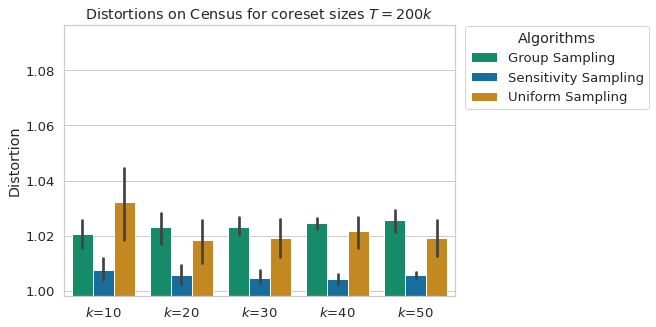

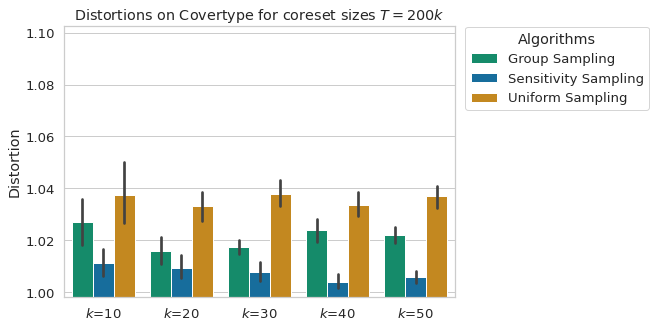

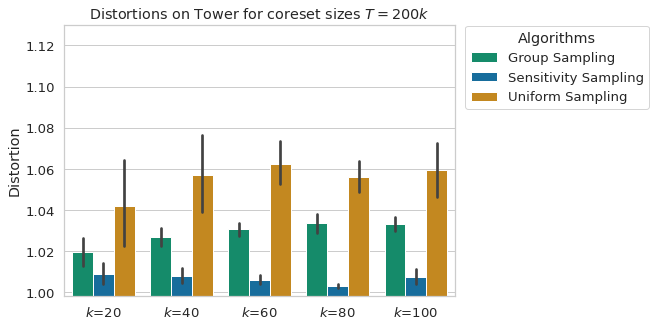

In [10]:
coreset_size_factors = df_cost_data["coreset_size_factor"].unique()
data_sets = np.sort(df_cost_data["dataset"].unique())

forward = lambda x: x**(1/10)
inverse = lambda x: x**10

with sns.plotting_context("notebook", font_scale=1.2):
    for j, data_set in enumerate(data_sets):
        fig, ax = plt.subplots(figsize=(7, 5))
        f2 = df_cost_data["dataset"] == data_set
        df_filtered = df_cost_data[f2].copy()
        df_filtered.sort_values(by=["k", "algorithm"], inplace=True)
        sns.barplot(data=df_filtered, x="k_formatted", y="distortion", hue="algorithm", ax=ax, palette=algorithm_colors)
        ax.set_title(f"Distortions on {data_set} for coreset sizes $T=200k$")
        ax.set_ylabel(f"Distortion")
        ax.set_xlabel("")
        ax.set_ylim(bottom= 0.998)
        
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        # fig.savefig(f"figures/plot-distortions-{data_set.lower()}.pdf", bbox_inches="tight")

## Real Costs

In [11]:
add_combined_mean_std(df=df_aggr_costs, attr="real_cost", g_format=True)
df_results_table = pd.pivot_table(
    data=df_aggr_costs,
    values="real_cost_mean_std",
    index=["dataset", "k", "coreset_size_factor"],
    columns=["algorithm"],
    aggfunc=lambda x: ' '.join(x)
)
df_results_table

algorithm                               Group Sampling Sensitivity Sampling  \
dataset   k   coreset_size_factor                                             
Census    10  200.0                2.54e+08 (7.73e+06)  2.57e+08 (1.20e+07)   
          20  200.0                1.90e+08 (5.27e+06)  1.93e+08 (3.73e+06)   
          30  200.0                1.63e+08 (3.99e+06)  1.64e+08 (3.96e+06)   
          40  200.0                1.42e+08 (2.15e+06)  1.44e+08 (5.00e+06)   
          50  200.0                1.28e+08 (1.75e+06)  1.32e+08 (3.72e+06)   
Covertype 10  200.0                3.45e+11 (2.53e+09)  3.44e+11 (2.79e+09)   
          20  200.0                2.07e+11 (2.31e+09)  2.07e+11 (1.93e+09)   
          30  200.0                1.57e+11 (1.34e+09)  1.57e+11 (8.25e+08)   
          40  200.0                1.31e+11 (6.80e+08)  1.31e+11 (6.02e+08)   
          50  200.0                1.15e+11 (1.10e+09)  1.15e+11 (8.82e+08)   
Tower     20  200.0                6.33e+08 (1.34e+07)  6.42e+08 (1.98e+07)   
          40  200.0                3.38e+08 (8.29e+06)  3.40e+08 (7.63e+06)   
          60  200.0                2.44e+08 (1.63e+06)  2.46e+08 (2.57e+06)   
          80  200.0                1.96e+08 (2.54e+06)  1.98e+08 (1.91e+06)   
          100 200.0                1.66e+08 (8.34e+05)  1.67e+08 (1.39e+06)   

algorithm                             Uniform Sampling  
dataset   k   coreset_size_factor                       
Census    10  200.0                2.50e+08 (4.27e+06)  
          20  200.0                1.91e+08 (2.83e+06)  
          30  200.0                1.60e+08 (2.69e+06)  
          40  200.0                1.42e+08 (1.51e+06)  
          50  200.0                1.29e+08 (1.41e+06)  
Covertype 10  200.0                3.47e+11 (3.56e+09)  
          20  200.0                2.06e+11 (1.08e+09)  
          30  200.0                1.57e+11 (1.22e+09)  
          40  200.0                1.31e+11 (3.10e+08)  
          50  200.0                1.15e+11 (6.26e+08)  
Tower     20  200.0                6.41e+08 (1.49e+07)  
          40  200.0                3.40e+08 (2.61e+06)  
          60  200.0                2.48e+08 (1.56e+06)  
          80  200.0                1.99e+08 (2.14e+06)  
          100 200.0                1.68e+08 (1.12e+06)

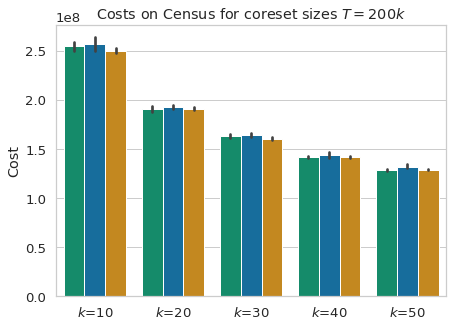

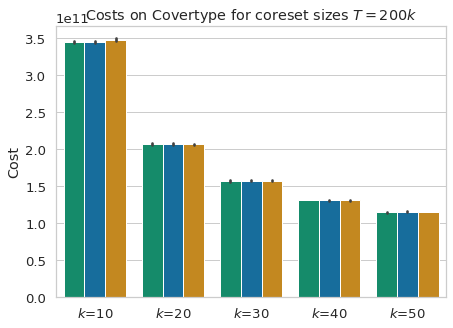

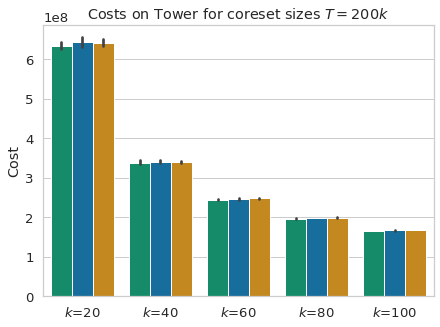

In [12]:
data_sets = np.sort(df_cost_data["dataset"].unique())

with sns.plotting_context("notebook", font_scale=1.2):
    for j, data_set in enumerate(data_sets):
        fig, ax = plt.subplots(figsize=(7, 5))
        f2 = df_cost_data["dataset"] == data_set
        df_filtered = df_cost_data[f2].copy()
        df_filtered.sort_values(by=["k", "algorithm"], inplace=True)
        sns.barplot(data=df_filtered, x="k_formatted", y="real_cost", hue="algorithm", ax=ax, palette=algorithm_colors)
        
        ax.set_title(f"Costs on {data_set} for coreset sizes $T=200k$")
        ax.set_ylabel(f"Cost")
        ax.set_xlabel("")
        
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left').set_visible(False)
        # fig.savefig(f"figures/plot-input-costs-{data_set.lower()}.pdf", bbox_inches="tight")

## Coreset costs

In [13]:
add_combined_mean_std(df=df_aggr_costs, attr="coreset_cost", g_format=True)

df_results_table = pd.pivot_table(
    data=df_aggr_costs,
    values="coreset_cost_mean_std",
    index=["dataset", "k", "coreset_size_factor"],
    columns=["algorithm"],
    aggfunc=lambda x: ' '.join(x)
)
df_results_table

algorithm                               Group Sampling Sensitivity Sampling  \
dataset   k   coreset_size_factor                                             
Census    10  200.0                2.49e+08 (8.15e+06)  2.56e+08 (1.25e+07)   
          20  200.0                1.86e+08 (6.06e+06)  1.93e+08 (3.41e+06)   
          30  200.0                1.59e+08 (4.33e+06)  1.64e+08 (4.74e+06)   
          40  200.0                1.38e+08 (2.14e+06)  1.44e+08 (4.57e+06)   
          50  200.0                1.25e+08 (2.23e+06)  1.33e+08 (3.71e+06)   
Covertype 10  200.0                3.36e+11 (5.98e+09)  3.48e+11 (3.04e+09)   
          20  200.0                2.04e+11 (3.66e+09)  2.07e+11 (2.79e+09)   
          30  200.0                1.54e+11 (1.79e+09)  1.57e+11 (2.16e+09)   
          40  200.0                1.28e+11 (1.08e+09)  1.31e+11 (9.44e+08)   
          50  200.0                1.12e+11 (9.60e+08)  1.15e+11 (1.19e+09)   
Tower     20  200.0                6.21e+08 (1.97e+07)  6.44e+08 (2.19e+07)   
          40  200.0                3.29e+08 (9.23e+06)  3.40e+08 (7.30e+06)   
          60  200.0                2.37e+08 (1.30e+06)  2.45e+08 (2.89e+06)   
          80  200.0                1.90e+08 (3.10e+06)  1.98e+08 (2.18e+06)   
          100 200.0                1.60e+08 (1.16e+06)  1.66e+08 (1.50e+06)   

algorithm                             Uniform Sampling  
dataset   k   coreset_size_factor                       
Census    10  200.0                2.43e+08 (8.20e+06)  
          20  200.0                1.87e+08 (3.23e+06)  
          30  200.0                1.57e+08 (3.55e+06)  
          40  200.0                1.39e+08 (1.60e+06)  
          50  200.0                1.27e+08 (1.23e+06)  
Covertype 10  200.0                3.36e+11 (7.33e+09)  
          20  200.0                2.00e+11 (1.99e+09)  
          30  200.0                1.51e+11 (1.19e+09)  
          40  200.0                1.27e+11 (9.87e+08)  
          50  200.0                1.11e+11 (1.00e+09)  
Tower     20  200.0                6.19e+08 (2.12e+07)  
          40  200.0                3.22e+08 (8.24e+06)  
          60  200.0                2.34e+08 (4.27e+06)  
          80  200.0                1.88e+08 (2.95e+06)  
          100 200.0                1.59e+08 (3.52e+06)

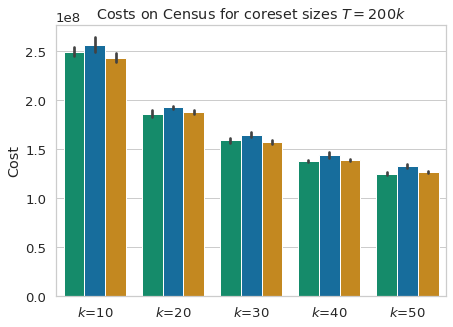

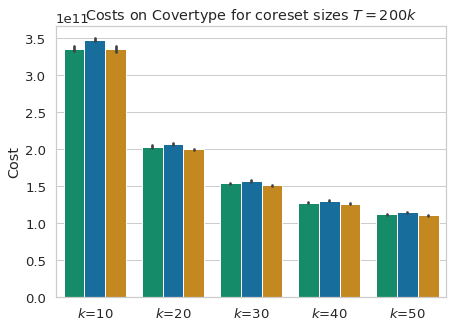

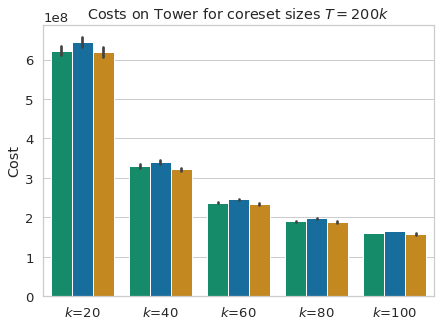

In [14]:
data_sets = np.sort(df_cost_data["dataset"].unique())

with sns.plotting_context("notebook", font_scale=1.2):
    for j, data_set in enumerate(data_sets):
        fig, ax = plt.subplots(figsize=(7, 5))
        f2 = df_cost_data["dataset"] == data_set
        df_filtered = df_cost_data[f2].copy()
        df_filtered.sort_values(by=["k", "algorithm"], inplace=True)
        sns.barplot(data=df_filtered, x="k_formatted", y="coreset_cost", hue="algorithm", ax=ax, palette=algorithm_colors)
        
        ax.set_title(f"Costs on {data_set} for coreset sizes $T=200k$")
        ax.set_ylabel(f"Cost")
        ax.set_xlabel("")
        # ax.set_yscale("log")
        ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left').set_visible(False)
        # fig.savefig(f"figures/plot-coreset-costs-{data_set.lower()}.pdf", bbox_inches="tight")